## Load data

In [1]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore")
random_state = 12041500

In [2]:
df_train = pd.read_json("./data/synthetic_data_CTGANSynthesizer.json")
df_train_backup = pd.read_json("./data/synthetic_data_CTGANSynthesizer.json")
df_test = pd.read_json("./data/testset.json")

df_train.drop(columns=['fnlwgt'], inplace=True)
df_train_backup.drop(columns=['fnlwgt'], inplace=True)
df_test.drop(columns=['fnlwgt'], inplace=True)

ratio_features = ["age", "capital-gain", "capital-loss", "hours-per-week"]
ordinal_features = ["education-num"]
nominal_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
target = 'income'

In [3]:
from sklearn.utils import resample

data_less_equal_50k_Husband = df_train[df_train['income'] == 0 & (df_train['relationship'] == 'Husband')]
data_greater_50k_Husband = df_train[df_train['income'] == 1 & (df_train['relationship'] == 'Husband')]
data_unequal_Husbad = df_train[(df_train['relationship'] != 'Husband')]

data_less_equal_50k_Husband_undersampled = resample(data_less_equal_50k_Husband, replace=False, n_samples=int(len(data_less_equal_50k_Husband)*0.25), random_state=random_state)

biased_data = pd.concat([data_unequal_Husbad, data_greater_50k_Husband, data_less_equal_50k_Husband_undersampled])

df_train = biased_data.sample(frac=1, random_state=random_state).reset_index(drop=True)
df_train.drop_duplicates(inplace=True)

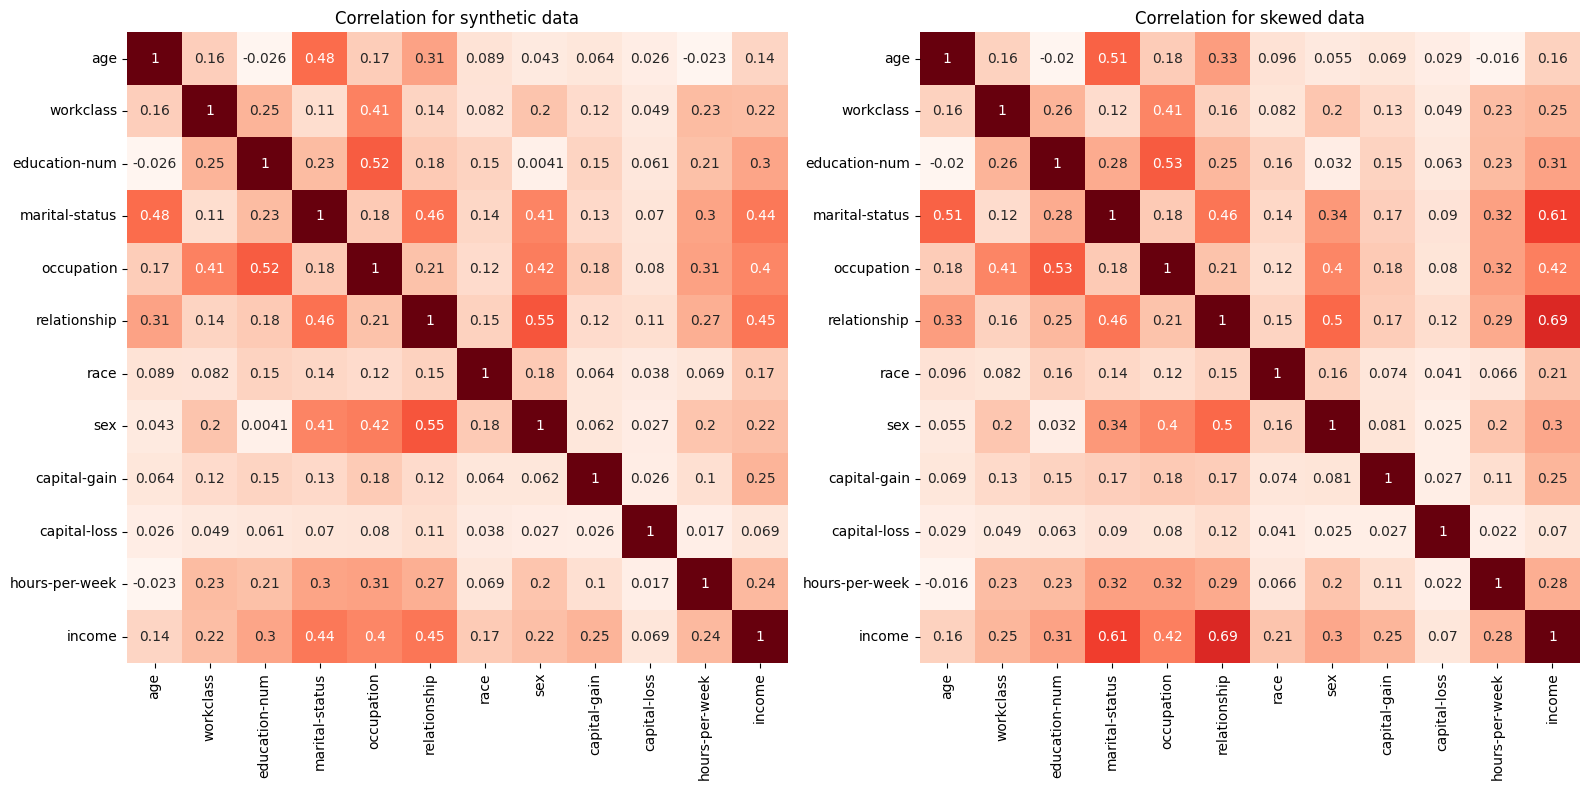

In [4]:
from dython.nominal import associations
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate associations for two datasets
assoc1 = associations(df_train_backup, compute_only=True)
assoc2 = associations(df_train, compute_only=True)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot the first association matrix
sns.heatmap(assoc1['corr'], ax=ax1, cmap="Reds", annot=True, cbar=False)
ax1.set_title('Correlation for synthetic data')

# Plot the second association matrix
sns.heatmap(assoc2['corr'], ax=ax2, cmap="Reds", annot=True, cbar=False)
ax2.set_title('Correlation for skewed data')

# Display the plots
plt.tight_layout()
plt.show()


## Train baseline

In [5]:
from sklearn.linear_model import LogisticRegression
from utils import create_model, train_and_evaluate, describe_model

In [6]:
clf = LogisticRegression(max_iter=1000, random_state=random_state)

In [7]:
## Train baseline
model = create_model(clf, nominal_features)
y_test, y_pred = train_and_evaluate(model, df_train, df_test, target, drop_na=True)
metrics = describe_model(y_test, y_pred, verbose=True)

Metric         Value               
Accuracy       0.784
Precision      0.726
Recall         0.779
F1             0.740


## Fairness Evaluation

In [8]:
from utils import split_data
from utils_fairness import search_bias, calc_fairness_score, explain_detected_bias

In [9]:
X_train, y_train = split_data(df_train, target, drop_na=True)

In [10]:
model = create_model(clf, nominal_features)
model.fit(X_train, y_train)
probs = pd.Series(model.predict_proba(X_train)[:, 1]) # we select for target label

In [ ]:
# privileged_subset, _ = search_bias(X_train, y_train, probs, 1, penalty=1)

In [ ]:
# print(privileged_subset)

In [11]:
privileged_subset = ({'relationship': ['Husband']}, 0)

In [12]:
calc_fairness_score(df_train, privileged_subset[0].keys(), target, verbose=True)

Sensitive Attributes: ['relationship']

         Group Distance  Proportion  Counts   P-Value
       Husband    0.524    0.229794    7253  0.00e+00
 Not-in-family   -0.165    0.374014   11805 4.94e-324
     Own-child   -0.223    0.120014    3788 4.94e-324
     Unmarried   -0.206    0.133067    4200 3.35e-301
Other-relative   -0.217    0.044641    1409 4.28e-118
          Wife    0.052    0.098470    3108  2.49e-11

Weighted Mean Statistical Distance: 0.2512407420712662


In [13]:
explain_detected_bias(df_train, probs, target, privileged_subset[0])

Our detected privileged group has a size of 7403, we observe 0.7579 as the average probability of earning >50k, but our model predicts 0.2451


## Fairness Metrics

In [14]:
from utils_fairness import transform_to_bias_dataset, describe_fairness, scan_and_calculate_fairness, plot_fairness_metrics

In [15]:
df_train_bias = transform_to_bias_dataset(df_train, list(privileged_subset[0].keys()), list(privileged_subset[0].values()), verbose=True)
df_test_bias = transform_to_bias_dataset(df_test, list(privileged_subset[0].keys()), list(privileged_subset[0].values()), verbose=True)

1401 Na rows removed!
202 Na rows removed!


In [16]:
model = create_model(clf, nominal_features)
y_test, y_pred = train_and_evaluate(model, df_train, df_train, target, drop_na=True)
metrics = describe_fairness(df_train_bias[target], y_pred, list(privileged_subset[0].keys()), verbose=True)

Metric                          Value               
statistical_parity_difference   -0.848
average_odds_difference         -0.667
equal_opportunity_difference    -0.672
disparate_impact                0.041
theil_index                     0.075


In [ ]:
df_fairness_metrics, priviliged_subsets = pd.DataFrame(
    columns=[
        "statistical_parity_difference",
        "average_abs_odds_difference",
        "equal_opportunity_difference",
        "disparate_impact",
        "theil_index",
    ]
), {}

for i in [1e-17, 1e-10, 0.001, 0.01, 0.1, 0, 1, 5, 10, 25, 50, 100]:
    metrics, priv = scan_and_calculate_fairness(model, df_train, target, i)    
    df_fairness_metrics.loc[f"{i}"] = metrics.values()
    priviliged_subsets[f"{i}"] = priv

In [ ]:
df_fairness_metrics

In [ ]:
df_fairness_metrics.to_json("./results/fairness_metrics_synthetic.json")

## Mitigation

In [17]:
from tqdm import tqdm
from sklearn import clone
from aif360.algorithms.preprocessing import Reweighing
from utils_fairness import create_aif360_standardDataset, compute_metrics, reweight_mitigation
from utils import plot_metrics

### Reweighting

In [18]:
# create (un)privileged groups
privileged_groups = [{key: 1 for key in list(privileged_subset[0].keys())}]
unprivileged_groups = [{key: 0 for key in list(privileged_subset[0].keys())}]

In [19]:
# convert dataset
train_dataset = create_aif360_standardDataset(df_train.dropna(), nominal_features, target, 1, list(privileged_subset[0].keys()), list(privileged_subset[0].values()))
test_dataset = create_aif360_standardDataset(df_test.dropna(), nominal_features, target, 1, list(privileged_subset[0].keys()), list(privileged_subset[0].values()))

In [20]:
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
RW.fit(train_dataset)

train_dataset_reweight = RW.transform(train_dataset)

#### Baseline

In [21]:
model = clone(clf)
model.fit(train_dataset.features, train_dataset.labels.ravel())
y_pred = model.predict(test_dataset.features)

_ = describe_model(test_dataset.labels.ravel(), y_pred, verbose=True)

Metric         Value               
Accuracy       0.780
Precision      0.722
Recall         0.776
F1             0.735


In [22]:
y_pred = model.predict(train_dataset.features)
_ = describe_fairness(df_train_bias[target], y_pred, list(privileged_subset[0].keys()), verbose=True)

Metric                          Value               
statistical_parity_difference   -0.862
average_odds_difference         -0.698
equal_opportunity_difference    -0.712
disparate_impact                0.035
theil_index                     0.076


#### Mitigated Model

In [23]:
# mitigated model
model = clone(clf)
model.fit(train_dataset_reweight.features, train_dataset_reweight.labels.ravel(), sample_weight=train_dataset_reweight.instance_weights)
y_pred = model.predict(test_dataset.features)

_ = describe_model(test_dataset.labels.ravel(), y_pred, verbose=True)

Metric         Value               
Accuracy       0.825
Precision      0.779
Recall         0.701
F1             0.725


In [24]:
y_pred = model.predict(train_dataset.features)
_ = describe_fairness(df_train_bias[target], y_pred, list(privileged_subset[0].keys()), verbose=True)

Metric                          Value               
statistical_parity_difference   -0.197
average_odds_difference         0.090
equal_opportunity_difference    0.174
disparate_impact                0.346
theil_index                     0.169


#### Bias detection & mitigation until bias free

In [ ]:
df_fairness_metrics = pd.DataFrame(
    columns=[
        "statistical_parity_difference",
        "average_abs_odds_difference",
        "equal_opportunity_difference",
        "disparate_impact",
        "theil_index",
    ]
)

In [ ]:
df_metrics = pd.DataFrame(
    columns=['acc', 'prec', 'rec', 'f1']
)

In [ ]:
weights = None

weights_hist = [weights]
max_iter = 10
for i in tqdm(range(max_iter)):
    X_train, y_train = split_data(df_train, target, True)
    X_test, y_test = split_data(df_test, target, True)
    weights, model_metrics, fair_metrics = reweight_mitigation(clf, nominal_features, target, X_train, y_train, X_test, y_test, penalty=1, sample_weights=weights)
    if model_metrics is None and fair_metrics is None and weights is None:
        break

    df_metrics.loc[f"mitigation_{i}"] = model_metrics.values()
    df_fairness_metrics.loc[f"mitigation_{i}"] = fair_metrics.values()
    weights_hist.append(weights)

In [ ]:
def plot_fairness_metrics(data, label_pos, label_fair_pos_metrics, label_fair_di_pos):
    # Set up the color palette
    palette = sns.color_palette("husl", len(data.columns))
    
    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    # Plotting metrics except disparate impact
    non_disparate_metrics = data.columns[data.columns != "disparate_impact"]
    for i, metric in enumerate(non_disparate_metrics):
        axes[0].plot(data.index, data[metric], label=metric.replace('_', ' ').title(), color=palette[i])

    # Add a horizontal dotted line at y=0 with label "Fair"
    axes[0].axhline(y=0, color='black', linestyle='--')
    axes[0].text(x=data.index.max(), y=label_fair_pos_metrics, s="Fair", color='black', ha='left', va='center', fontsize=10)

    axes[0].set_xlabel("Penalty", fontsize=12)
    axes[0].set_ylabel("Metric Value", fontsize=12)
    axes[0].set_title("Bias Metrics vs. Penalty", fontsize=14)
    axes[0].grid(True)
    axes[0].tick_params(axis="x", rotation=45)
    
    # Plotting disparate impact
    axes[1].plot(data.index, data["disparate_impact"], label="Disparate Impact", color='purple')

    # Add a horizontal dotted line at y=1 with label "Fair"
    axes[1].axhline(y=0.8, color='black', linestyle='--')
    axes[1].text(x=data.index.max(), y=label_fair_di_pos, s="Fair", color='black', ha='left', va='center', fontsize=10)

    axes[1].set_xlabel("Penalty", fontsize=12)
    axes[1].set_ylabel("Disparate Impact Value", fontsize=12)
    axes[1].set_title("Disparate Impact vs. Penalty", fontsize=14)
    axes[1].grid(True)
    axes[1].tick_params(axis="x", rotation=45)

    # Combine legends from both plots
    handles, labels = axes[0].get_legend_handles_labels()
    handles.extend(axes[1].get_legend_handles_labels()[0:1])  # Add disparate impact handle from second plot
    labels.extend(["Disparate Impact"])

    # Set the legend in the first subplot
    axes[0].legend(handles, labels, title="Metrics", loc=label_pos, fontsize=10)

    plt.tight_layout()
    plt.show()

In [ ]:
plot_fairness_metrics(df_fairness_metrics, "lower left", -0.04, 0.78)

### Fair Learning

In [25]:
from utils import prepare_data_fair_learning, plot_fairlearning_results
from utils_fairness import get_fair_learning_scoring
from sklearn.model_selection import GridSearchCV
from aif360.sklearn.preprocessing import LearnedFairRepresentations

In [26]:
df_train_bias = transform_to_bias_dataset(df_train, list(privileged_subset[0].keys()), list(privileged_subset[0].values()), verbose=True)
df_test_bias = transform_to_bias_dataset(df_test, list(privileged_subset[0].keys()), list(privileged_subset[0].values()), verbose=True)

X_train, y_train, X_test, y_test = prepare_data_fair_learning(df_train_bias, df_test_bias, nominal_features, target)

1401 Na rows removed!
202 Na rows removed!


In [27]:
X_train['relationship'] = X_train.index
X_test['relationship'] = X_test.index

In [28]:
max_delta = get_fair_learning_scoring(list(privileged_subset[0].keys()))

In [29]:
lfr = LearnedFairRepresentations(
    list(privileged_subset[0].keys()),
    n_prototypes=20,
    max_iter=50,
    random_state=random_state,
)

In [30]:
params = {
    "reconstruct_weight": [1e-2, 1e-3, 1e-4],
    "target_weight": [100, 1000],
    "fairness_weight": [0, 100, 1000],
}

In [31]:
grid = GridSearchCV(lfr, params, scoring=max_delta, cv=3, n_jobs=-1).fit(
    X_train, y_train, priv_group=(1,) * len(list(privileged_subset[0].keys()))
)
res = pd.DataFrame(grid.cv_results_)

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/torch/_functorch/deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/torch/_functorch/deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/m

#### Baseline

In [32]:
model = clone(clf)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

_ = describe_model(y_test, y_pred, verbose=True)

Metric         Value               
Accuracy       0.783
Precision      0.725
Recall         0.779
F1             0.739


In [33]:
y_pred = model.predict(X_train)
_ = describe_fairness(df_train_bias[target], y_pred, list(privileged_subset[0].keys()), verbose=True)

Metric                          Value               
statistical_parity_difference   -0.859
average_odds_difference         -0.687
equal_opportunity_difference    -0.694
disparate_impact                0.038
theil_index                     0.075


#### Using Grid itself

In [34]:
_ = describe_model(y_test, grid.predict(X_test), verbose=True)

Metric         Value               
Accuracy       0.776
Precision      0.696
Recall         0.583
F1             0.589


In [35]:
_ = describe_fairness(y_train, grid.predict(X_train), list(privileged_subset[0].keys()) ,verbose=True)

Metric                          Value               
statistical_parity_difference   -0.426
average_odds_difference         -0.210
equal_opportunity_difference    -0.225
disparate_impact                0.163
theil_index                     0.142


#### Transforming data

In [36]:
model = clone(clf)
model.fit(grid.transform(X_train), y_train)
y_pred = model.predict(X_test)

_ = describe_model(y_test, y_pred, verbose=True)

Metric         Value               
Accuracy       0.759
Precision      0.380
Recall         0.500
F1             0.432


In [37]:
_ = describe_fairness(y_train, model.predict(X_train), list(privileged_subset[0].keys()), verbose=True)

Metric                          Value               
statistical_parity_difference   0.000
average_odds_difference         0.000
equal_opportunity_difference    0.000
disparate_impact                0.000
theil_index                     0.276


##### Also Transforming test data

In [38]:
_ = describe_model(y_test, model.predict(grid.transform(X_test)), verbose=True)

Metric         Value               
Accuracy       0.776
Precision      0.696
Recall         0.583
F1             0.590


In [39]:
_ = describe_fairness(y_train, model.predict(grid.transform(X_train)), list(privileged_subset[0].keys()) ,verbose=True)

Metric                          Value               
statistical_parity_difference   -0.495
average_odds_difference         -0.285
equal_opportunity_difference    -0.312
disparate_impact                0.139
theil_index                     0.130


Multiple Runs cannot be done, because of the dataset already needs to be one hot encoded for the mitigation, making the `search_bias` function unnecessary and returning not viable resolutions.

### Fair Learning

In [40]:
%matplotlib inline
# Load all necessary packages

from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult
from aif360.algorithms.preprocessing.lfr import LFR

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import numpy as np
from utils_fairness import create_aif360_standardDataset

In [41]:
# create (un)privileged groups
privileged_groups = [{key: 1 for key in list(privileged_subset[0].keys())}]
unprivileged_groups = [{key: 0 for key in list(privileged_subset[0].keys())}]

In [42]:
TR = LFR(unprivileged_groups=unprivileged_groups,
         privileged_groups=privileged_groups,
         k=10, Ax=0.01, Ay=1000, Az=0,
         verbose=1,
         seed=random_state
)

TR = TR.fit(train_dataset, maxiter=5000, maxfun=1000)

step: 0, loss: 4340.64694365157, L_x: 372766.62827259366,  L_y: 0.6129806609256335,  L_z: 0.0050157499188675765
step: 250, loss: 4340.646941775758, L_x: 372766.6282726118,  L_y: 0.61298065904964,  L_z: 0.005015750847350962
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          450     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.34065D+03    |proj g|=  3.64656D+01
step: 500, loss: 4286.4757490103175, L_x: 372766.26484013157,  L_y: 0.5588131006090014,  L_z: 0.005275868181273008
step: 750, loss: 4286.475751947848, L_x: 372766.2648401481,  L_y: 0.5588131035463666,  L_z: 0.0052758674246097485

At iterate    1    f=  4.28648D+03    |proj g|=  1.59107D+01
step: 1000, loss: 4253.958955446069, L_x: 372764.55248167895,  L_y: 0.526313430629279,  L_z: 0.009832837936927564
step: 1250, loss: 4253.958955810853, L_x: 372764.55248171405,  L_y: 0.5263134309937126,  L_z: 0.009832837618656354

At iterate    2    f=  4.25

In [43]:
# Transform training data and align features
train_dataset_lfr = TR.transform(train_dataset)

In [44]:
cnt = {}
for i in train_dataset_lfr.labels.ravel():
    cnt[i] = cnt.get(i, 0) + 1

cnt

{0.0: 31563}

#### Baseline

In [45]:
model = clone(clf)
model.fit(train_dataset.features, train_dataset.labels.ravel())
y_pred = model.predict(test_dataset.features)

_ = describe_model(test_dataset.labels.ravel(), y_pred, verbose=True)

Metric         Value               
Accuracy       0.780
Precision      0.722
Recall         0.776
F1             0.735


In [46]:
y_pred = model.predict(train_dataset.features)
_ = describe_fairness(df_train_bias[target], y_pred, list(privileged_subset[0].keys()), verbose=True)

Metric                          Value               
statistical_parity_difference   -0.862
average_odds_difference         -0.698
equal_opportunity_difference    -0.712
disparate_impact                0.035
theil_index                     0.076


#### Mitigation

In [47]:
_ = describe_model(df_test_bias[target], [0]*len(df_test_bias[target]), verbose=True)

Metric         Value               
Accuracy       0.759
Precision      0.380
Recall         0.500
F1             0.432


In [48]:
_ = describe_fairness(df_train_bias[target], np.array([0]*len(df_train_bias)), list(privileged_subset[0].keys()), verbose=True)

Metric                          Value               
statistical_parity_difference   0.000
average_odds_difference         0.000
equal_opportunity_difference    0.000
disparate_impact                0.000
theil_index                     0.276


### Disparate Impact Remover

In [49]:
import numpy as np
from tqdm import tqdm

from aif360.algorithms.preprocessing import DisparateImpactRemover

In [50]:
index = train_dataset.feature_names.index('relationship')

In [51]:
fairness_metrics = []
utility_metrics = []
for level in tqdm(np.linspace(0, 1, 10)):
    di = DisparateImpactRemover(repair_level=level)
    train_repd = di.fit_transform(train_dataset)
    test_repd = di.fit_transform(test_dataset)
    
    X_tr = np.delete(train_repd.features, index, axis=1)
    X_te = np.delete(test_repd.features, index, axis=1)
    y_tr = train_repd.labels.ravel()
    
    model = clone(clf)
    model.fit(X_tr, y_tr)

    utility_metrics.append(describe_model(test_repd.labels.ravel(), model.predict(X_te), verbose=False))
    fairness_metrics.append(describe_fairness(df_train_bias[target], model.predict(X_tr), list(privileged_subset[0].keys()), verbose=False))


100%|██████████| 10/10 [01:04<00:00,  6.41s/it]


In [52]:
fairness_metrics

[{'statistical_parity_difference': -0.6916812759587757,
  'average_odds_difference': -0.42911068642349104,
  'equal_opportunity_difference': -0.4321438380470502,
  'disparate_impact': 0.09083648160039862,
  'theil_index': 0.08460806570558126},
 {'statistical_parity_difference': -0.7076221796872886,
  'average_odds_difference': -0.4530742879176717,
  'equal_opportunity_difference': -0.4598836342456759,
  'disparate_impact': 0.08660194531555357,
  'theil_index': 0.0835320884242415},
 {'statistical_parity_difference': -0.7052425802273735,
  'average_odds_difference': -0.45194055443466874,
  'equal_opportunity_difference': -0.46178955289079004,
  'disparate_impact': 0.08511457084794487,
  'theil_index': 0.08421932648631221},
 {'statistical_parity_difference': -0.7454294434286487,
  'average_odds_difference': -0.5043336566789872,
  'equal_opportunity_difference': -0.5025552336252215,
  'disparate_impact': 0.08019738802518059,
  'theil_index': 0.07985430960473469},
 {'statistical_parity_diff

In [53]:
max_index, max_disparate_impact_row = max(enumerate(fairness_metrics), key=lambda x: x[1]['disparate_impact'])
max_disparate_impact_row

{'statistical_parity_difference': -0.6916812759587757,
 'average_odds_difference': -0.42911068642349104,
 'equal_opportunity_difference': -0.4321438380470502,
 'disparate_impact': 0.09083648160039862,
 'theil_index': 0.08460806570558126}

In [54]:
utility_metrics[max_index]

{'Accuracy': 0.8143618689244277,
 'Precision': 0.7510472192194431,
 'Recall': 0.7900333966024178,
 'F1': 0.7653885882613767}